In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.core.interactiveshell import InteractiveShell
import copy
import matplotlib.pyplot as plt
import os

from torch.utils.data       import DataLoader
from matplotlib.pyplot      import close, figure, imshow, savefig, show, title
from matplotlib.lines       import Line2D
from os.path                import join
from random                 import sample
from re                     import split
from torch                  import device, no_grad
from torch.cuda             import is_available
from torch.nn               import Linear, Module, MSELoss, ReLU, Sequential, Sigmoid
from torch.optim            import Adam
from torch.utils.data       import DataLoader
from torchvision.datasets   import MNIST
from torchvision.utils      import make_grid
from torchvision.transforms import Compose, ToTensor
from torchvision.utils      import make_grid
from torch.utils.data       import Dataset
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd         import Variable
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns


InteractiveShell.ast_node_interactivity = "all"
plt.style.use('bmh')

%matplotlib inline

In [30]:
df = sns.load_dataset("flights")
df["feat1"] = 1
df.head()

,year,month,passengers,feat1
0,1949,Jan,112,1
1,1949,Feb,118,1
2,1949,Mar,132,1
3,1949,Apr,129,1
4,1949,May,121,1


In [31]:
# basic functions: all input should be df and column definition
from dataclasses import dataclass, field


@dataclass
class ColumnDef:
    org_y_col: str
    org_time_col: str
    org_cal_col: list[str] = field(default_factory=list)
    org_num_col: list[str] = field(default_factory=list)
    
    
    Y = "y"
    col_time ="col_time"
    col_cal: list[str] = field(default_factory=list)
    col_num: list[str] = field(default_factory=list)
    scaler = None
    def col_features(self):
        return self.col_cal + self.col_num
    
    def col_all(self):
        return self.col_cal + self.col_num + [self.Y]
    
    def add_col_cat(self, name):
        if name in self.col_cal:
            print(f"duplicate: %r")
            return
        self.col_cal.append(name)
        
    def add_col_num(self, name):
        if name in self.col_num:
            print(f"duplicate: {name}")
            return
        self.col_num.append(name)
        
    def add_scaler(self, scaler):
        self.scaler = scaler

In [34]:
def to_clean_df(df, col_def):
    from datetime import datetime
    df["time_str"] = df.apply(lambda x: '%s, %s'% (x["month"], x["year"]), axis=1)
    df["time"] = df.apply(lambda x: datetime.strptime(x["time_str"], '%b, %Y').date(), axis=1)
    
    df.index = df[col_def.org_time_col]
    df[col_def.col_time] = df[col_def.org_time_col]
    df[col_def.col_time] = pd.to_datetime(df[col_def.col_time])
    df[col_def.Y] = df[col_def.org_y_col]
    drop_cols = []
    if col_def.Y != col_def.org_y_col:
        drop_cols.append(col_def.org_y_col)
    if col_def.col_time != col_def.org_time_col:
        drop_cols.append(col_def.org_time_col)
    df.drop(columns=drop_cols, inplace=True)

    
simple_def = ColumnDef(org_y_col="passengers", org_time_col="time", org_num_col=["feat1"])
to_clean_df(df, simple_def)
df.head()

,year,month,feat1,time_str,col_time,y
time,,,,,,
1949-01-01,1949,Jan,1,"Jan, 1949",1949-01-01,112
1949-02-01,1949,Feb,1,"Feb, 1949",1949-02-01,118
1949-03-01,1949,Mar,1,"Mar, 1949",1949-03-01,132
1949-04-01,1949,Apr,1,"Apr, 1949",1949-04-01,129
1949-05-01,1949,May,1,"May, 1949",1949-05-01,121


In [35]:
class StatsFeaturesGenerator:
    def __init__(self, df, target_col, col_def: ColumnDef, windows_list=[3, 6, 12, 24, 48, 72]):
        self.df = df
        self.x_col = target_col
        self.col_def = col_def
        self.col_time = self.col_def.col_time
        self.funcs = ['count', 'sum', 'mean']
        self.windows_list = windows_list
        self.last_time_feature_len = 3
        self.last_same_period_len = 2

    def gen_features(self):
        self.df['month'] = self.df[self.col_time].dt.month
        self.df['day'] = self.df[self.col_time].dt.day
        self.df['hour'] = self.df[self.col_time].dt.hour
        self.df['dayofweek'] = self.df[self.col_time].dt.dayofweek +1
        
        self.col_def.add_col_cat('month')
        self.col_def.add_col_cat('day')
        self.col_def.add_col_cat('hour')
        self.col_def.add_col_cat('dayofweek')

        
        for i in range(self.last_time_feature_len):
            new_col_name = f'last{i}_{self.x_col}'
            self.df[new_col_name] = self.df[self.x_col].shift(i)
            self.col_def.add_col_num(new_col_name)
        
        for p_i in range(self.last_same_period_len):
            p_i_new_col_name = f'last{p_i}_hour_{self.x_col}'
            self.df[p_i_new_col_name] = self.df.groupby(
                [self.col_def.col_time])[self.x_col].shift(p_i)
            self.col_def.add_col_num(p_i_new_col_name)
        
        for w in self.windows_list:
            self.df = self._gen_lag_feature(self.df, self.x_col, window=w)
        
        for func in self.funcs:
            self.df = self._gen_group_features(self.df, self.x_col, [self.col_def.col_time], func)

    def _gen_lag_feature(self, df, x_col, window=3):
        rolled = df[x_col].rolling(window=window, min_periods=1)
        lag_mean = rolled.mean().reset_index()
        lag_max = rolled.max().reset_index()
        lag_sum = rolled.sum().reset_index()

        df[f'cnt_mean_lag{window}'] = lag_mean[x_col]
        df[f'cnt_max_lag{window}'] = lag_max[x_col]
        df[f'cnt_sum_lag{window}'] = lag_sum[x_col]
        self.col_def.add_col_num(f'cnt_mean_lag{window}')
        self.col_def.add_col_num(f'cnt_max_lag{window}')
        self.col_def.add_col_num(f'cnt_sum_lag{window}')

        return df

    def _gen_group_features(self, df, x_col, group_cols, func):
        aggregation_df = df.groupby(group_cols).agg({x_col: [func]})
        aggregation_df = aggregation_df.reset_index()
        aggregation_df.columns = group_cols + ['_'.join(group_cols)+"_"+x_col+"_"+func]

        df = df.merge(aggregation_df, how='left', on=group_cols)

        return df
    
    
feature_gen = StatsFeaturesGenerator(df=df, target_col=simple_def.Y, col_def=simple_def)
# feature_gen.col_def.col_time
feature_gen.gen_features()
# df.col_time.dtype
df.head()

'col_time'

,year,month,feat1,time_str,col_time,y,day,hour,dayofweek,last0_y,...,cnt_sum_lag12,cnt_mean_lag24,cnt_max_lag24,cnt_sum_lag24,cnt_mean_lag48,cnt_max_lag48,cnt_sum_lag48,cnt_mean_lag72,cnt_max_lag72,cnt_sum_lag72
time,,,,,,,,,,,,,,,,,,,,,
1949-01-01,1949,1,1,"Jan, 1949",1949-01-01,112,1,0,6,112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-02-01,1949,2,1,"Feb, 1949",1949-02-01,118,1,0,2,118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-03-01,1949,3,1,"Mar, 1949",1949-03-01,132,1,0,2,132,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-04-01,1949,4,1,"Apr, 1949",1949-04-01,129,1,0,5,129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-05-01,1949,5,1,"May, 1949",1949-05-01,121,1,0,7,121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
def to_transform(df, col_def: ColumnDef):
    # Transfer
    """
    - all feat_cols convert to np.float32
    - replace/drop np.nan, np.inf, -np.inf
    - Handle outlier, find outlier from another notebook
    - set_fact: scaler
    """
    df[col_def.col_all()] = df[col_def.col_all()].astype(np.float32)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.fillna(0.)
    
    data_scaler = MinMaxScaler()
    data_scaler.fit(df[col_def.col_all()])
    df[col_def.col_all()] = data_scaler.transform(
        df[col_def.col_all()]
    )
    col_def.add_scaler(data_scaler)
    return df

In [37]:
df = to_transform(df, simple_def)

Text(0.5, 0.98, 'Data Distribution Before and After Normalization ')

<Axes: title={'center': ' Before Normalization'}, ylabel='Frequency'>

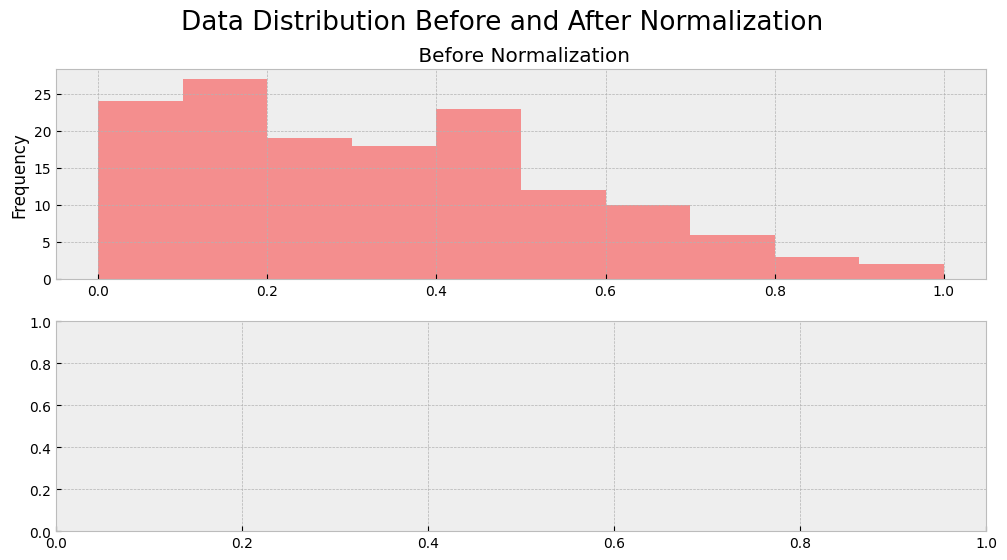

In [44]:
data = df[simple_def.Y]

fig, axs = plt.subplots(2)
 
fig.suptitle('Data Distribution Before and After Normalization ',fontsize = 19)
pd.DataFrame(data).plot(kind='hist',ax = axs[0] , alpha=.4 , figsize=[12,6], legend = False,title = ' Before Normalization',color ='red') 
# pd.DataFrame(data_normalized).plot(kind='hist', ax = axs[1] ,figsize=[12,6], alpha=.4 , legend = False,title = ' After Normalization'\
#                                          ,color = 'blue')

# df to dataloader
- set fact: train_loader, test_loader

In [ ]:


len(df[[y_col]])
df[[y_col]].values.shape



all_x.shape, all_y.shape
print("print top 5")
all_x[:5]
all_y[:5]

In [46]:
def _to_dataloader(df, col_def):
    timeseq_length = 10
    test_split = 0.2
    shuffle_dataset = True
    random_seed = 1234
    batch_size = 200


    dataset = TimeSeriesDataset(df, col_def, timeseq_length)
    
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    # count out split size
    split = int(np.floor(test_split * dataset_size))
    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)


    train_indices, test_indices = (
        indices[split:], indices[:split]
    )
    print(len(train_indices), len(test_indices))

    # creating data samplers and loaders:
    train_sampler, test_sampler = (
        SubsetRandomSampler(train_indices),
        SubsetRandomSampler(test_indices)
    )

    train_loader, test_loader = (
        DataLoader(dataset, batch_size=batch_size, sampler=train_sampler),
        DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    )
    return train_loader, test_loader


class TimeSeriesDataset(Dataset):
    
    def __init__(self, df, col_def: ColumnDef, timeseq_length):
        self.col_def = col_def
        # self.x, self.y = self.sliding_windows(df[col_def.Y].values, timeseq_length)
        self.x, self.y = self.sliding_windows_mutli_features(df, timeseq_length)
        self.n_samples = self.x.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples
    
    
    def sliding_windows(self, data, seq_length):
        x = []
        y = []

        for i in range(len(data)-seq_length-1):
            _x = data[i:(i+seq_length)]
            _y = data[i+seq_length]
            x.append(_x)
            y.append(_y)

        return np.array(x),np.array(y)
    
    def sliding_windows_mutli_features(self, df, seq_length):
        x = []
        y = []

        for i in range((df.shape[0])-seq_length-1):
            _x = df[i:(i+seq_length)][self.col_def.col_features()].values
            _y = df.iloc[i+seq_length][self.col_def.Y]
            x.append(_x)
            y.append(_y)

        x, y = np.array(x), np.array(y).reshape(-1,1)
        print(x.shape, y.shape)
        return x, y


train_loader, test_loader = _to_dataloader(df, simple_def)

(133, 10, 27) (133, 1)
107 26


# Model definition with drill run

In [47]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.dropout = nn.Dropout(p=0.2)
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        print("hidde shape before view", h_out.shape)
        
        h_out = h_out.view(-1, self.hidden_size)
        print("hidde shape after view", h_out.shape)
        
        out = self.fc(h_out)
        out = self.dropout(out)
       
        return out


class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))
    

class LSTM2(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM2, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        
        self.LSTM2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.2)
       
        
        
        self.fc1 = nn.Linear(hidden_size,256)
        self.bn1 = nn.BatchNorm1d(256,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dp1 = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(256, 128)
            
        self.bn2 = nn.BatchNorm1d(128,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dp2 = nn.Dropout(0.2)
        self.fc3= nn.Linear(128, 1)
        self.relu = nn.ReLU()
       
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
       
        _, (hn, cn) = self.LSTM2(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        
        x0 = self.fc1(final_state)
        x0 = self.bn1(x0)
        x0 = self.dp1(x0)
        x0 = self.relu(x0)
        
        x0 = self.fc2(x0)
        x0 = self.bn2(x0)
        x0 = self.dp2(x0)
        
        x0 = self.relu(x0)
        
        out = self.fc3(x0)
        #print(out.size())
        return out
    

In [48]:
num_epochs = 500
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 4
num_classes = 1
device = 'cpu'
best_val_loss = 100
# dev = 'cuda:0'


# model = LSTM(num_classes, input_size, hidden_size, num_layers)
input_shape = len(simple_def.col_features())
# input_size = 1


model = LSTM2(num_classes, input_shape, hidden_size, num_layers)
model.to(device)
model

LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [49]:
# !pip install fastprogress
from fastprogress import master_bar, progress_bar


model.to(device)
optimizer     = Adam(model.parameters(), lr = learning_rate)
criterion     = MSELoss().to(device)
scheduler     = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,  
    patience=500,
    factor =0.5,
    min_lr=1e-7, 
    eps=1e-08
)

for epoch in progress_bar(range(num_epochs)):
    for batch_features, batch_y in train_loader: # 21, 10, 27
        model.train()
        print(batch_features.shape)
        batch_features = batch_features.view(-1, 10, input_shape).to(device)
        outputs        = model(batch_features)
        optimizer.zero_grad()
        
        train_loss     = criterion(outputs, batch_y)
        train_loss.backward()
        optimizer.step()

LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


LSTM2(
  (LSTM2): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

torch.Size([107, 10, 27])


In [ ]:
# issue every time runs are different result
# gpu

torch.Tensor(np.array(all_x)).to(device)[:3]
model(torch.Tensor(np.array(all_x)).to(device)[:3])
torch.Tensor(np.array(all_y)).to(device)[:3]

print("parameter:")
model.state_dict()

In [ ]:
torch.save(model.state_dict(), "/kaggle/working/model.v1")

In [ ]:
# Feature Extraction


feature_extract_model = LSTM(num_classes, input_size, hidden_size, num_layers)

feature_extract_model.load_state_dict(torch.load("/kaggle/working/model.v1"))
feature_extract_model

In [ ]:
feature_extract_model.dropout.requires_grad = False
feature_extract_model.lstm.requires_grad = False
feature_extract_model.fc = nn.Linear(
    in_features=512, out_features=1, bias=True
)
feature_extract_model.fc.requires_grad = True

In [ ]:
peak_df_y_col, peak_df_time_col = "value", "time"


peak_df = pd.DataFrame(
{
    "time": pd.date_range(start='1/1/2018', periods=8*4),
    "value": [0, 0, 0, 1]* 8
})
peak_df.index = peak_df[peak_df_time_col]

peak_df[[peak_df_y_col, peak_df_time_col]].head(10)

In [ ]:
peak_num_cols = []
peak_cat_cols = []
peak_feat_cols = peak_cat_cols + peak_num_cols

In [ ]:
peak_df.replace([np.inf, -np.inf], np.nan, inplace=True)
peak_df = peak_df.fillna(0.)

peak_df[[peak_df_y_col] + feat_cols] = peak_df[[peak_df_y_col] + num_cols].astype(np.float32)
peak_df.info()

peak_scaler = MinMaxScaler().fit(peak_df[[peak_df_y_col] + feat_cols])
peak_df[[peak_df_y_col] + peak_feat_cols] = scaler.transform(peak_df[[peak_df_y_col] + peak_feat_cols])
peak_df.head()

In [ ]:
peak_df_all_x, peak_df_all_y = sliding_windows(
    peak_df[[peak_df_y_col]].values, timeseq_length)

In [ ]:
dataset = TimeSeriesDataset(peak_df_all_x, peak_df_all_y)

# creat data indices for training and testing splits
dataset_size = len(dataset)
indices = list(range(dataset_size))
# count out split size
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# creating data samplers and loaders:
train_sampler, test_sampler = (
    SubsetRandomSampler(train_indices),
    SubsetRandomSampler(test_indices)
)

peak_df_train_loader, peak_df_test_loader = (
    DataLoader(dataset, batch_size=batch_size, sampler=train_sampler),
    DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
)

In [ ]:
model(torch.Tensor(np.array(all_x)).to(device)[:3])
peak_df_all_y[:3]
feature_extract_model(torch.Tensor(np.array(peak_df_all_x)).to(device)[:3])

In [ ]:
# !pip install fastprogress
from fastprogress import master_bar, progress_bar


feature_extract_model.to(device)
feature_extract_optimizer     = Adam(feature_extract_model.parameters(), lr = learning_rate)
feature_extract_criterion     = MSELoss().to(device)
feature_extract_scheduler     = torch.optim.lr_scheduler.ReduceLROnPlateau(
    feature_extract_optimizer,  
    patience=500,
    factor =0.5,
    min_lr=1e-7, 
    eps=1e-08
)

for epoch in progress_bar(range(num_epochs)):
    for batch_features, batch_y in train_loader:
        loss = 0
        feature_extract_model.train()
        
        batch_features = batch_features.view(-1, 10, 1).to(device)
        outputs        = feature_extract_model(batch_features)
        feature_extract_optimizer.zero_grad()
        
        train_loss     = feature_extract_criterion(outputs, batch_y)
        train_loss.backward()
        feature_extract_optimizer.step()

In [ ]:
model(torch.Tensor(np.array(all_x)).to(device)[:3])
peak_df_all_y[:3]
feature_extract_model(torch.Tensor(np.array(peak_df_all_x)).to(device)[:3])

In [ ]:
fine_tune_model = LSTM(num_classes, input_size, hidden_size, num_layers)

fine_tune_model.load_state_dict(torch.load("/kaggle/working/model.v1"))
fine_tune_model

In [ ]:
fine_tune_model.dropout.requires_grad = True
fine_tune_model.lstm.requires_grad = True
fine_tune_model.fc.requires_grad = True

In [ ]:
# !pip install fastprogress
from fastprogress import master_bar, progress_bar


fine_tune_model.to(device)
fine_tune_optimizer     = Adam(fine_tune_model.parameters(), lr = learning_rate)
fine_tune_criterion     = MSELoss().to(device)
fine_tune_scheduler     = torch.optim.lr_scheduler.ReduceLROnPlateau(
    fine_tune_optimizer,  
    patience=500,
    factor =0.5,
    min_lr=1e-7, 
    eps=1e-08
)

for epoch in progress_bar(range(num_epochs)):
    for batch_features, batch_y in train_loader:
        loss = 0
        fine_tune_model.train()
        
        batch_features = batch_features.view(-1, 10, 1).to(device)
        outputs        = fine_tune_model(batch_features)
        fine_tune_optimizer.zero_grad()
        
        train_loss     = fine_tune_criterion(outputs, batch_y)
        train_loss.backward()
        fine_tune_optimizer.step()

In [ ]:
model(torch.Tensor(np.array(peak_df_all_x)).to(device)[:3])
peak_df_all_y[:3]
feature_extract_model(torch.Tensor(np.array(peak_df_all_x)).to(device)[:3])

fine_tune_model(torch.Tensor(np.array(peak_df_all_x)).to(device)[:3])

In [ ]:
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))


model.eval()

train_predict = model(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()

## Inverse Normalize 
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

dates_list = [i for i in range(len(data_predict))]
## Add dates
df_predict = pd.DataFrame(data_predict)
print(df_predict.shape)
df_predict = df_predict.set_index([dates_list])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list])

# Plot 
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(df_predict, dataY_plot)

In [ ]:
plt.xlim(1000, 25000)
plt.ylim(1000, 25000)
plt.scatter(dataY_plot, df_predict)

In [ ]:
torch.save(model.state_dict(), "/kaggle/working/model.v1")

In [ ]:
model.fc.bias.requires_grad = True

In [ ]:
# freeze layer
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Unfreeze last layer
for param in resnet18.fc.parameters():
    param.requires_grad = True